### AAI-530 Final Project: Delivery Drone Flight Predictions
<br>Group 6: Ahmed Salem, Matt Thompson, Darin Verduzco
<br>GitHub: https://github.com/caliskate/delivery-drone-flight-predictions
<br>Dataset source: https://doi.org/10.1184/R1/12683453.v1

### Dataset descriptions:
(196 flights total)

| **Variable**             | **Description**                                                                                                                                              |
|--------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------|
| flight                  | An integer that represents the code of the flight performed. A flight is defined as the dataset recorded from take-off to landing on a predefined route.      |
| time                    | Seconds elapsed after flight start time.                                                                                                                      |
| wind_speed              | Airspeed provided by the anemometer in meters per second (m/s).                                                                                               |
| wind_angle              | Angle in degrees (deg) of the air flowing through the anemometer with respect to the north.                                                                   |
| battery_voltage         | System voltage in Volts (V) measured immediately after the battery.                                                                                           |
| battery_current         | System current in Ampere (A) measured immediately after the battery.                                                                                          |
| position_x              | Longitude of the aircraft in degrees (deg).                                                                                                                   |
| position_y              | Latitude of the aircraft in degrees (deg).                                                                                                                    |
| position_z              | Altitude of the aircraft in meters (m) with respect to sea level.                                                                                             |
| orientation_x           | Aircraft orientation in quaternions.                                                                                                                          |
| linear_acceleration_x   | Ground acceleration in meters per squared second (m/s²).                                                                                                      |
| linear_acceleration_y   | Ground acceleration in meters per squared second (m/s²).                                                                                                      |
| linear_acceleration_z   | Ground acceleration in meters per squared second (m/s²).                                                                                                      |
| speed                   | Programmed horizontal ground speed during cruise in meters per second (m/s).                                                                                  |
| altitude                | Predefined altitude in meters (m). The aircraft takes off vertically until it reaches the preset altitude.                                                    |
| payload                 | Mass of the payload attached to the aircraft in grams (g). The payload used was confined in a standard USPS Small Flat Rate Box.                              |
| date                    | Date of the flight.                                                                                                                                           |
| time_day                | Local time when the flight started in the 24-hour format.                                                                                                     |
| route                   | Route type (see directly below):                                                                                                                              |
|                          - R1 to R7: Full flights completing a cruise movement.                                                                                                         |
|                          - A1: Ancillary ground test with no propellers and no motor movement.                                                                                          |
|                          - A2: Ancillary ground test with no propellers and minimum movement.                                                                                           |
|                          - A3: Ancillary ground test with propellers and minimum movement.                                                                                              |
|                          - H: Hover test with no horizontal movement.                                                                                                                   |


### Import Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Import dataset from local dir

In [2]:
drone_raw_df =  pd.read_csv("flights.csv", low_memory = False)
drone_raw_df.head()

,flight,time,wind_speed,wind_angle,battery_voltage,battery_current,position_x,position_y,position_z,orientation_x,...,angular_z,linear_acceleration_x,linear_acceleration_y,linear_acceleration_z,speed,payload,altitude,date,time_day,route
0,1,0.0,0.1,12.0,24.222174,0.087470,-79.782396,40.458047,269.332402,0.001772,...,0.006815,0.004258,-0.120405,-9.811137,4.0,0.0,25,2019-04-07,10:13,R5
1,1,0.2,0.1,3.0,24.227180,0.095421,-79.782396,40.458047,269.332056,0.001768,...,0.002034,0.006175,-0.116397,-9.810392,4.0,0.0,25,2019-04-07,10:13,R5
2,1,0.3,0.1,352.0,24.225929,0.095421,-79.782396,40.458047,269.333081,0.001768,...,-0.000874,0.002696,-0.128592,-9.809440,4.0,0.0,25,2019-04-07,10:13,R5
3,1,0.5,0.1,354.0,24.224678,0.095421,-79.782396,40.458047,269.334648,0.001775,...,0.002443,0.002024,-0.128271,-9.810159,4.0,0.0,25,2019-04-07,10:13,R5
4,1,0.6,0.1,359.0,24.210905,0.079518,-79.782396,40.458047,269.336178,0.001775,...,-0.006425,0.008271,-0.119890,-9.812125,4.0,0.0,25,2019-04-07,10:13,R5


In [3]:
drone_raw_df.dtypes

flight                     int64
time                     float64
wind_speed               float64
wind_angle               float64
battery_voltage          float64
battery_current          float64
position_x               float64
position_y               float64
position_z               float64
orientation_x            float64
orientation_y            float64
orientation_z            float64
orientation_w            float64
velocity_x               float64
velocity_y               float64
velocity_z               float64
angular_x                float64
angular_y                float64
angular_z                float64
linear_acceleration_x    float64
linear_acceleration_y    float64
linear_acceleration_z    float64
speed                    float64
payload                  float64
altitude                  object
date                      object
time_day                  object
route                     object
dtype: object

In [4]:
# Make a copy of the dataframe to be edited
drone_df_edited = drone_raw_df.copy()

In [5]:
# Show unique altitude values
unique_altitude = drone_df_edited['altitude'].unique()
print(unique_altitude)

['25' '50' '75' '100' '0' '3' '25-50-100-25']


In [6]:
# Count altitudes with dash
altitude_with_dash_count = drone_df_edited['altitude'].str.contains('-').sum()
print(altitude_with_dash_count)

2185


In [7]:
# Drop (non-numeric) rows with dash in altitude, no documentation on this value explanation
drone_df_edited = drone_df_edited[~drone_df_edited['altitude'].str.contains('-')]
# Convert altitude to numeric
drone_df_edited.loc[:, 'altitude'] = pd.to_numeric(drone_df_edited['altitude'], errors='coerce')

### Create datetime column (seconds remain in decimal)

In [8]:
# Combine time, time_day and date columns into a datetime column
drone_df_edited['datetime'] = (
    pd.to_datetime(drone_df_edited['date'] + ' ' + drone_df_edited['time_day']) +
    pd.to_timedelta(drone_df_edited['time'], unit='s')
)

drone_df_edited.head()

,flight,time,wind_speed,wind_angle,battery_voltage,battery_current,position_x,position_y,position_z,orientation_x,...,linear_acceleration_x,linear_acceleration_y,linear_acceleration_z,speed,payload,altitude,date,time_day,route,datetime
0,1,0.0,0.1,12.0,24.222174,0.087470,-79.782396,40.458047,269.332402,0.001772,...,0.004258,-0.120405,-9.811137,4.0,0.0,25,2019-04-07,10:13,R5,2019-04-07 10:13:00.000
1,1,0.2,0.1,3.0,24.227180,0.095421,-79.782396,40.458047,269.332056,0.001768,...,0.006175,-0.116397,-9.810392,4.0,0.0,25,2019-04-07,10:13,R5,2019-04-07 10:13:00.200
2,1,0.3,0.1,352.0,24.225929,0.095421,-79.782396,40.458047,269.333081,0.001768,...,0.002696,-0.128592,-9.809440,4.0,0.0,25,2019-04-07,10:13,R5,2019-04-07 10:13:00.300
3,1,0.5,0.1,354.0,24.224678,0.095421,-79.782396,40.458047,269.334648,0.001775,...,0.002024,-0.128271,-9.810159,4.0,0.0,25,2019-04-07,10:13,R5,2019-04-07 10:13:00.500
4,1,0.6,0.1,359.0,24.210905,0.079518,-79.782396,40.458047,269.336178,0.001775,...,0.008271,-0.119890,-9.812125,4.0,0.0,25,2019-04-07,10:13,R5,2019-04-07 10:13:00.600


In [9]:
desc = drone_df_edited.describe()

# Force the printout not to use scientific notation
desc[desc.columns[:-1]] = desc[desc.columns[:-1]].apply(lambda x: x.apply("{0:.4f}".format))
desc

,flight,time,wind_speed,wind_angle,battery_voltage,battery_current,position_x,position_y,position_z,orientation_x,...,velocity_z,angular_x,angular_y,angular_z,linear_acceleration_x,linear_acceleration_y,linear_acceleration_z,speed,payload,datetime
count,255711.0000,255711.0000,255711.0000,255711.0000,255711.0000,255711.0000,255711.0000,255711.0000,255711.0000,255711.0000,...,255711.0000,255711.0000,255711.0000,255711.0000,255711.0000,255711.0000,255711.0000,255711.0000,255711.0000,255711
mean,161.4543,97.8696,4.3336,169.2189,22.4382,17.9392,-77.7566,39.4301,295.7696,-0.0102,...,0.2958,-0.0012,0.0001,0.0287,-0.3170,0.0165,-9.7958,7.3023,240.6555,2019-07-06 06:10:41.084902144
min,1.0000,0.0000,0.0000,0.0000,18.8108,-0.3260,-79.9465,0.0000,0.0000,-0.5464,...,-4.0158,-2.2796,-3.6749,-1.8575,-5.8895,-9.1080,-22.6879,0.0000,0.0000,2019-04-07 10:13:00
25%,112.0000,46.2100,1.5000,79.0000,21.5177,7.6417,-79.7828,40.4589,271.2835,-0.0241,...,-0.1405,-0.0433,-0.0384,-0.0407,-0.6916,-0.2032,-9.8959,4.0000,0.0000,2019-06-24 11:16:00.200000
50%,165.0000,93.1000,3.3000,177.0000,22.3115,21.9310,-79.7827,40.4590,292.1257,-0.0019,...,0.0290,-0.0003,0.0001,0.0011,-0.0524,0.0100,-9.8011,8.0000,250.0000,2019-07-03 16:58:48
75%,222.0000,141.5000,6.5000,244.0000,23.1642,25.2628,-79.7823,40.4591,325.2835,0.0103,...,0.8488,0.0412,0.0407,0.0514,0.1796,0.2267,-9.6618,10.0000,500.0000,2019-07-18 14:27:09.200000
max,277.0000,428.2900,18.1000,359.0000,25.8949,47.1938,0.0000,40.4597,376.1887,0.4150,...,5.8426,3.0228,2.8337,2.1724,4.6478,7.1399,-3.8305,12.0000,750.0000,2019-10-24 09:47:14.810000
std,70.9368,62.7548,3.4912,101.3437,1.2003,10.8540,12.5587,6.3685,58.4780,0.0475,...,1.4526,0.1165,0.1753,0.2510,0.7706,0.4617,0.4617,3.2132,211.0019,NaN


In [10]:
# Count missing values
na_values = drone_df_edited.isna().sum()
print(na_values)

flight                   0
time                     0
wind_speed               0
wind_angle               0
battery_voltage          0
battery_current          0
position_x               0
position_y               0
position_z               0
orientation_x            0
orientation_y            0
orientation_z            0
orientation_w            0
velocity_x               0
velocity_y               0
velocity_z               0
angular_x                0
angular_y                0
angular_z                0
linear_acceleration_x    0
linear_acceleration_y    0
linear_acceleration_z    0
speed                    0
payload                  0
altitude                 0
date                     0
time_day                 0
route                    0
datetime                 0
dtype: int64


In [11]:
# Count number of flight times per day
drone_df_edited.groupby('date')['time_day'].nunique()

date
2019-04-07     6
2019-05-06    11
2019-06-05     3
2019-06-11    13
2019-06-19    15
2019-06-24    12
2019-06-25    12
2019-06-29     8
2019-07-01     7
2019-07-03    16
2019-07-09    12
2019-07-10    13
2019-07-15    20
2019-07-18    13
2019-07-24    16
2019-08-05    21
2019-09-19     6
2019-10-24     3
Name: time_day, dtype: int64

In [12]:
average_flights_per_day = drone_df_edited.groupby('date')['time_day'].nunique().mean()
print(f'Average flights per day:{average_flights_per_day: 0.2f}')

Average flights per day: 11.50


In [13]:
number_of_flight_dates = drone_df_edited['date'].nunique()
print(f'Number of unique flight dates: {number_of_flight_dates}')

Number of unique flight dates: 18


### <b><u>Prediction 1 (time series): 
<b><u>Predict drone flight energy consumption for future time intervals based on payload, altitude, speed, wind.</b></u>
<br><br><b>predicted/dependent variables:</b> battery_current, battery_voltage
<br><b>feature/independent variables:</b> payload, altitude, speed, wind_speed, wind_angle

### <b><u> Prediction 2 (Deep Neural Network Classification):</b></u>
<b><u>Classify optimal flight parameters (altitude, speed, payload) that minimize energy consumption
<br>based upon flight conditions (e.g., wind speed and battery level).</b></u>
<br><br><b>predicted/dependent variables:</b> altitude, speed, payload
<br><b>feature/independent variables:</b> wind_speed, wind_angle, battery_voltage, battery_current 
<br><br><b>other possible independent variables:</b> position (x,y,z), orientation(x,y,z), velocity (x,y,z), angular (x,y,z), linear acceleration (x,y,z))

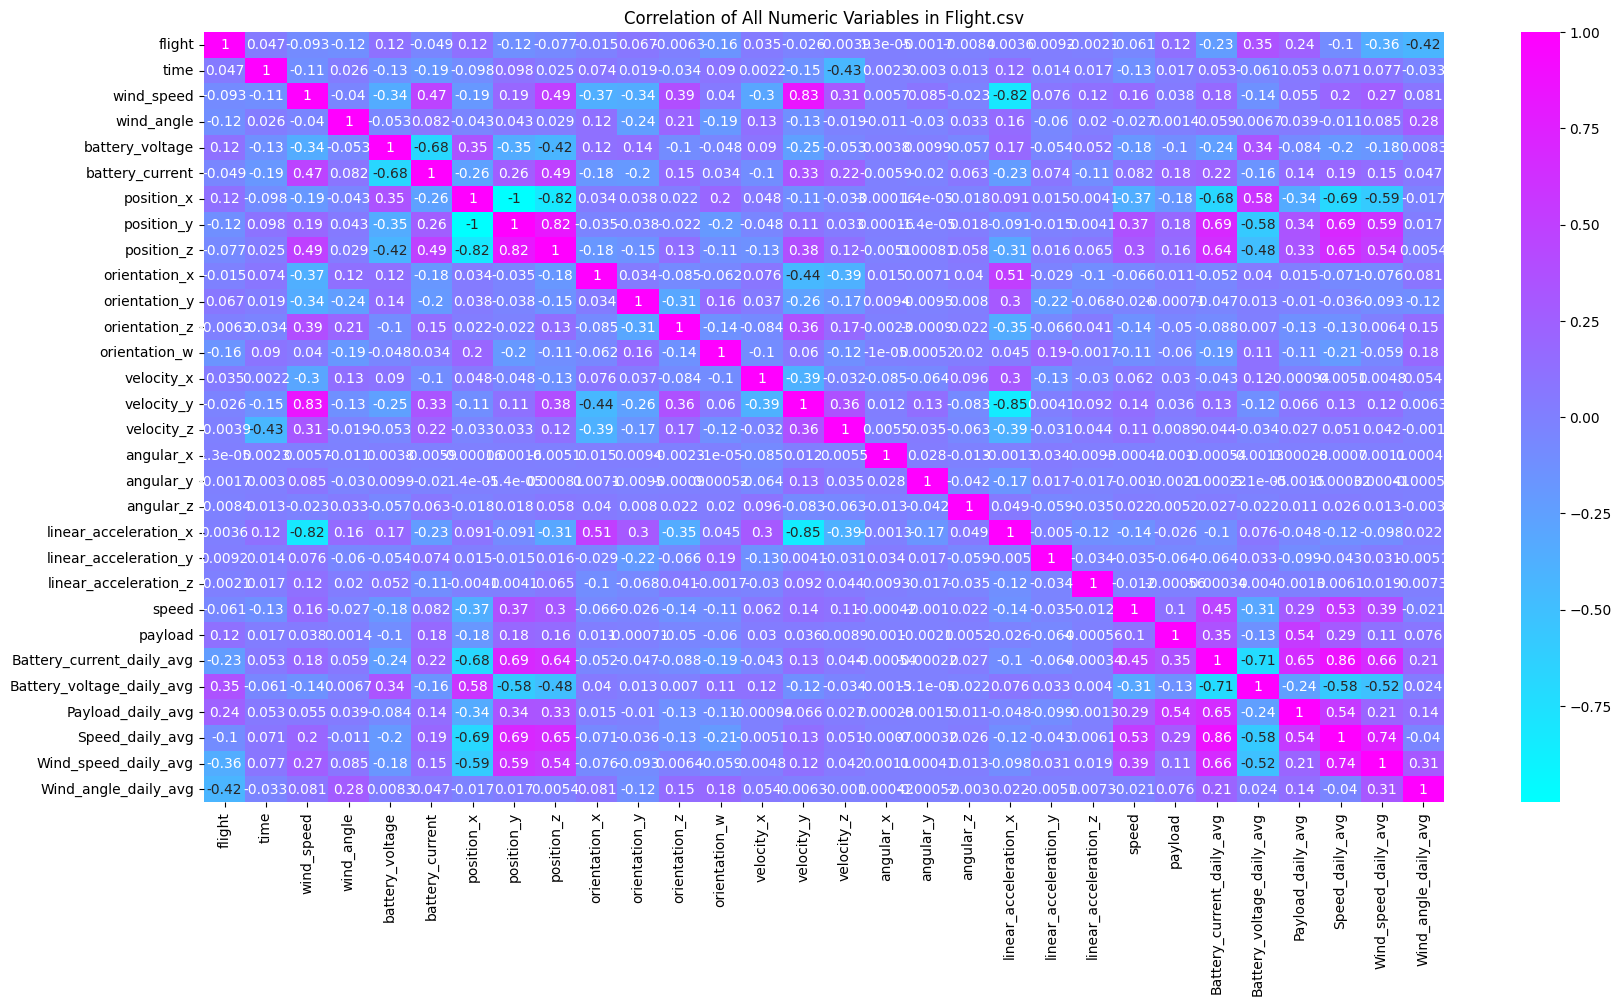

In [41]:
# Correlation of all numeric columns
plt.figure(figsize=(20, 10)) # Width, height
plt.title('Correlation of All Numeric Variables in Flight.csv')
# Select only numeric columns
numeric_df = drone_df_edited.select_dtypes(include=['number'])

# Calculate the correlation matrix
corr_matrix = numeric_df.corr()

# Plot the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='cool')
plt.show()

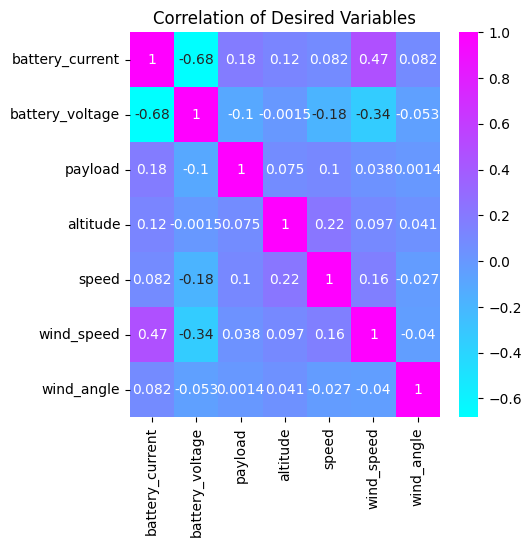

In [50]:
# Define desired columns
prediction1_columns = [
    'battery_current',
    'battery_voltage',
    'payload',
    'altitude',
    'speed',
    'wind_speed',
    'wind_angle'
]
# Correlation of desired columns
plt.figure(figsize=(5, 5)) # Width, height
plt.title('Correlation of Desired Variables')

# Calculate the correlation matrix
corr_matrix = drone_df_edited[prediction1_columns].corr()

# Plot the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='cool')
plt.show()

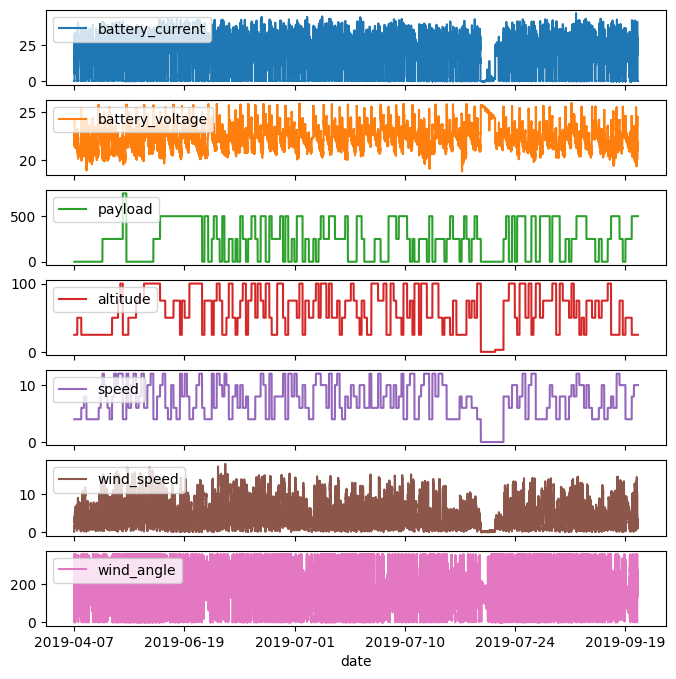

In [14]:
# Initial line plot of desired columns
ax = drone_df_edited.plot('date', prediction1_columns, subplots = True, figsize = (8,8))

# Align legend to upper left
for a in ax.flatten():
    a.legend(loc='upper left')

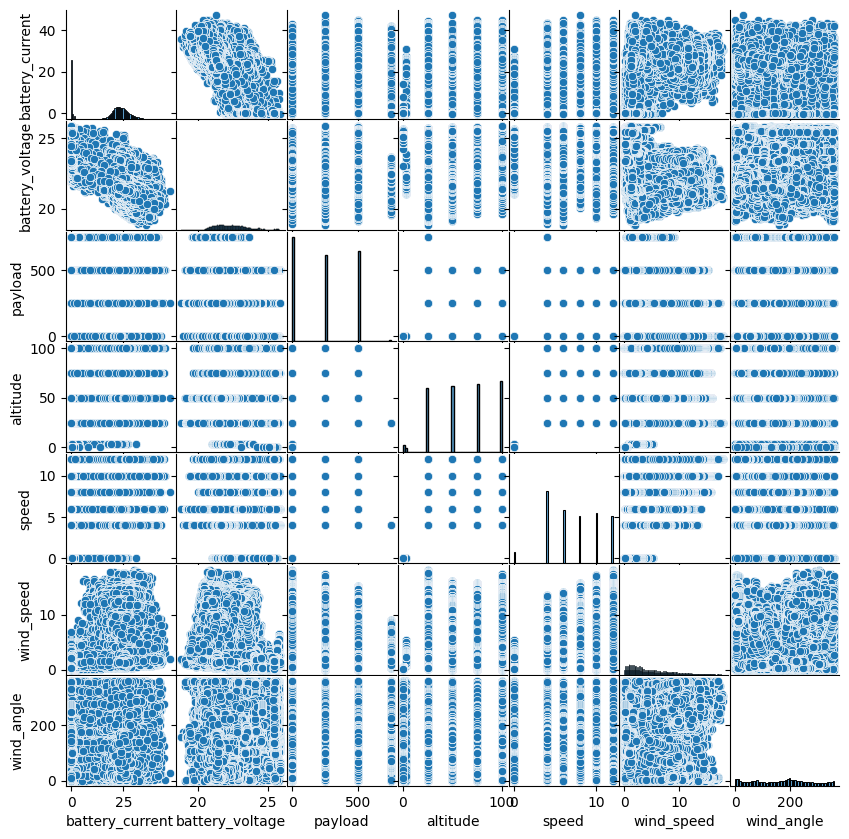

In [60]:
# Pairplot of desired columns
sns.pairplot(drone_df_edited[prediction1_columns], height=8) # Data and individual plot height
plt.gcf().set_size_inches(8, 8)  # Overall figure size
plt.show()

In [15]:
# Calculate daily averages
drone_df_edited[[
    'Battery_current_daily_avg',
    'Battery_voltage_daily_avg',
    'Payload_daily_avg',
    'Altitude_daily_avg',
    'Speed_daily_avg',
    'Wind_speed_daily_avg',
    'Wind_angle_daily_avg'
]] = drone_df_edited.groupby(pd.Grouper(key="datetime", freq="1D"))[prediction1_columns].transform('mean')

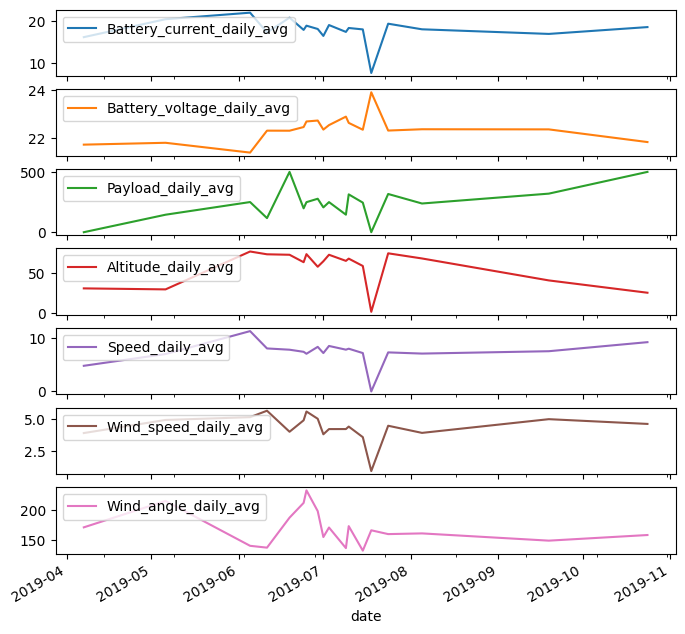

In [16]:
# Sort dataframe by date
drone_df_edited = drone_df_edited.sort_values('date')
# Convert to datetime to enable drop by time period (assisted by Chatgpt)
drone_df_edited['date'] = pd.to_datetime(drone_df_edited['date'])
# Keep 1st row of each date in new dataframe based 1 day period (assisted by Chatgpt)
df_unique_daily = drone_df_edited.loc[drone_df_edited['date'].dt.to_period('D').drop_duplicates().index]

# Build daily avg line plot
ax = df_unique_daily.plot(
    x='date',
    y=[
    'Battery_current_daily_avg',
    'Battery_voltage_daily_avg',
    'Payload_daily_avg',
    'Altitude_daily_avg',
    'Speed_daily_avg',
    'Wind_speed_daily_avg',
    'Wind_angle_daily_avg'
    ],
    subplots=True, figsize = (8,8)
)

# Align legend to upper left
for a in ax.flatten():
    a.legend(loc='upper left')

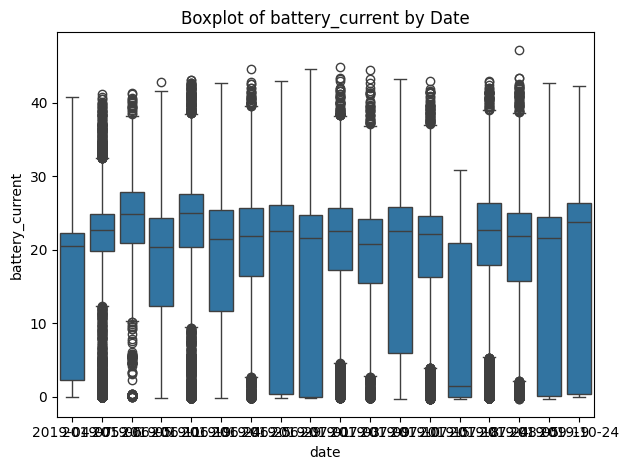

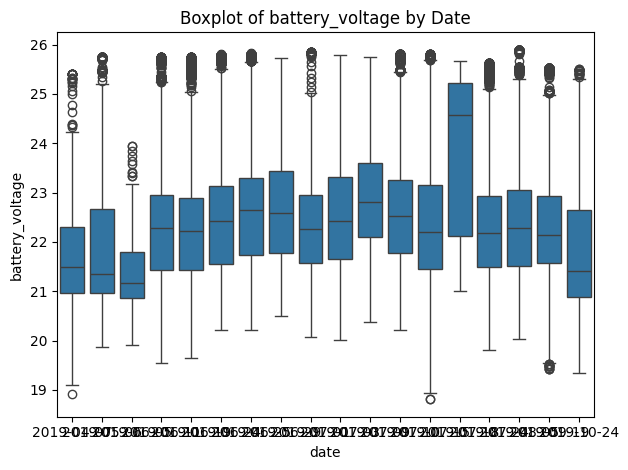

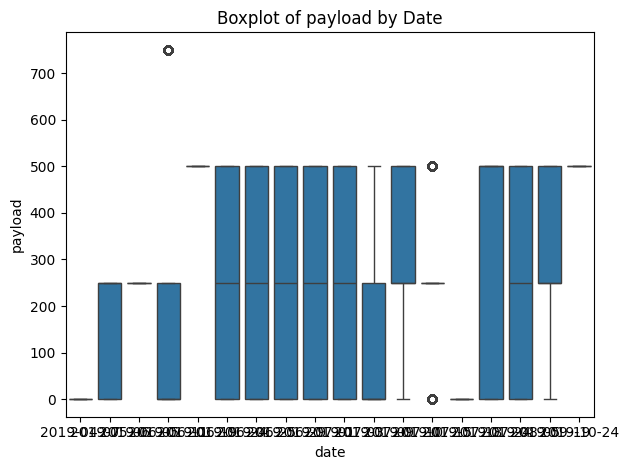

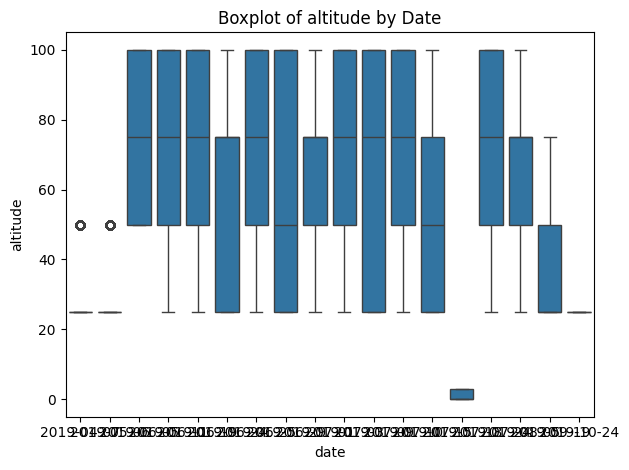

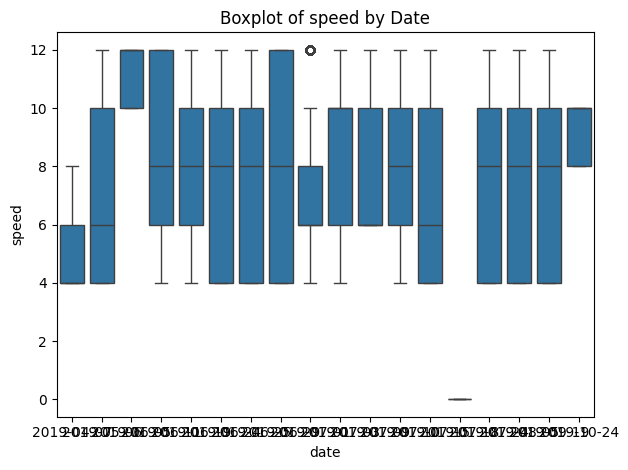

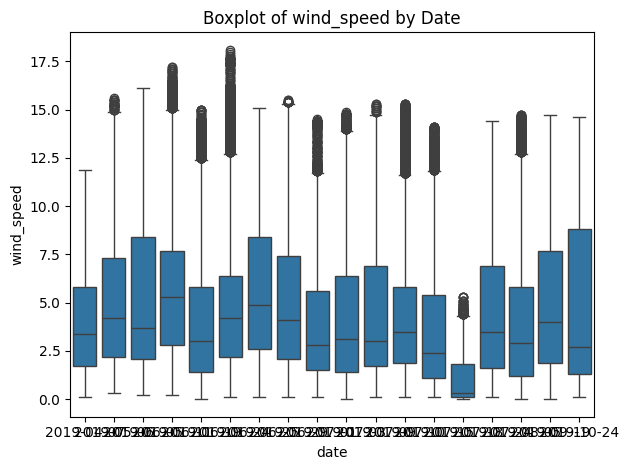

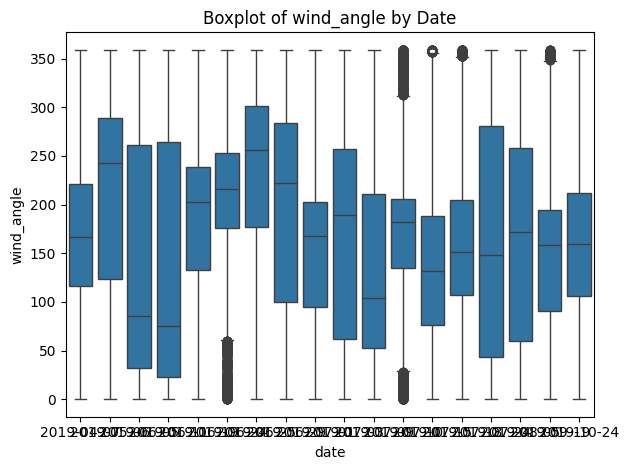

In [31]:
# Create boxplots by date for each desired variable
for col in prediction1_columns:
    sns.boxplot(x=drone_df_edited['date'], y=drone_df_edited[col])
    plt.title(f'Boxplot of {col} by Date')
    plt.tight_layout()
    plt.show()